<a href="https://colab.research.google.com/github/Danicoder/Especializacion_IA_BigData/blob/main/Te_damos_la_bienvenida_a_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##CASO PRÁCTICO KMEAMS: DETECCION DE TRANSACCIONES FRAUDULENTAS

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, recall_score, f1_score,precision_score
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics

In [27]:
def plot_data(X, y):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'k.', markersize=2)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'): #REPRESENTO LOS CLUSTERS DE LOS CENTROIDES A TRAVES DE LOS LIMITES DE DECISION
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, y, resolution=1000, show_centroids=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X, y)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

def purity_score(y_true, y_pred): # CALCULAMOS LA PUREZA
    # calcla la matriz de contingencia (LLamada Matriz de Confusion)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # devuelvo la pureza para evaluarla
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)


In [2]:
from google.colab import files
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [3]:
df = pd.read_csv("creditcard.csv")
df.head(10)

características

In [4]:
print("Número de características:", len(df.columns))
print("Longitud del conjunto de datos:", len(df))

Número de características: 31
Longitud del conjunto de datos: 284807


transacción legales e ilegales

In [5]:
df.value_counts('Class')

,count
Class,
0,284315
1,492


Visualizamos los tipos de datos

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Comprobamos valores nulos

In [7]:
df.isnull().any()

,0
Time,False
V1,False
V2,False
V3,False
V4,False
V5,False
V6,False
V7,False
V8,False
V9,False


percentiles

In [8]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Gráfcia en 2D

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


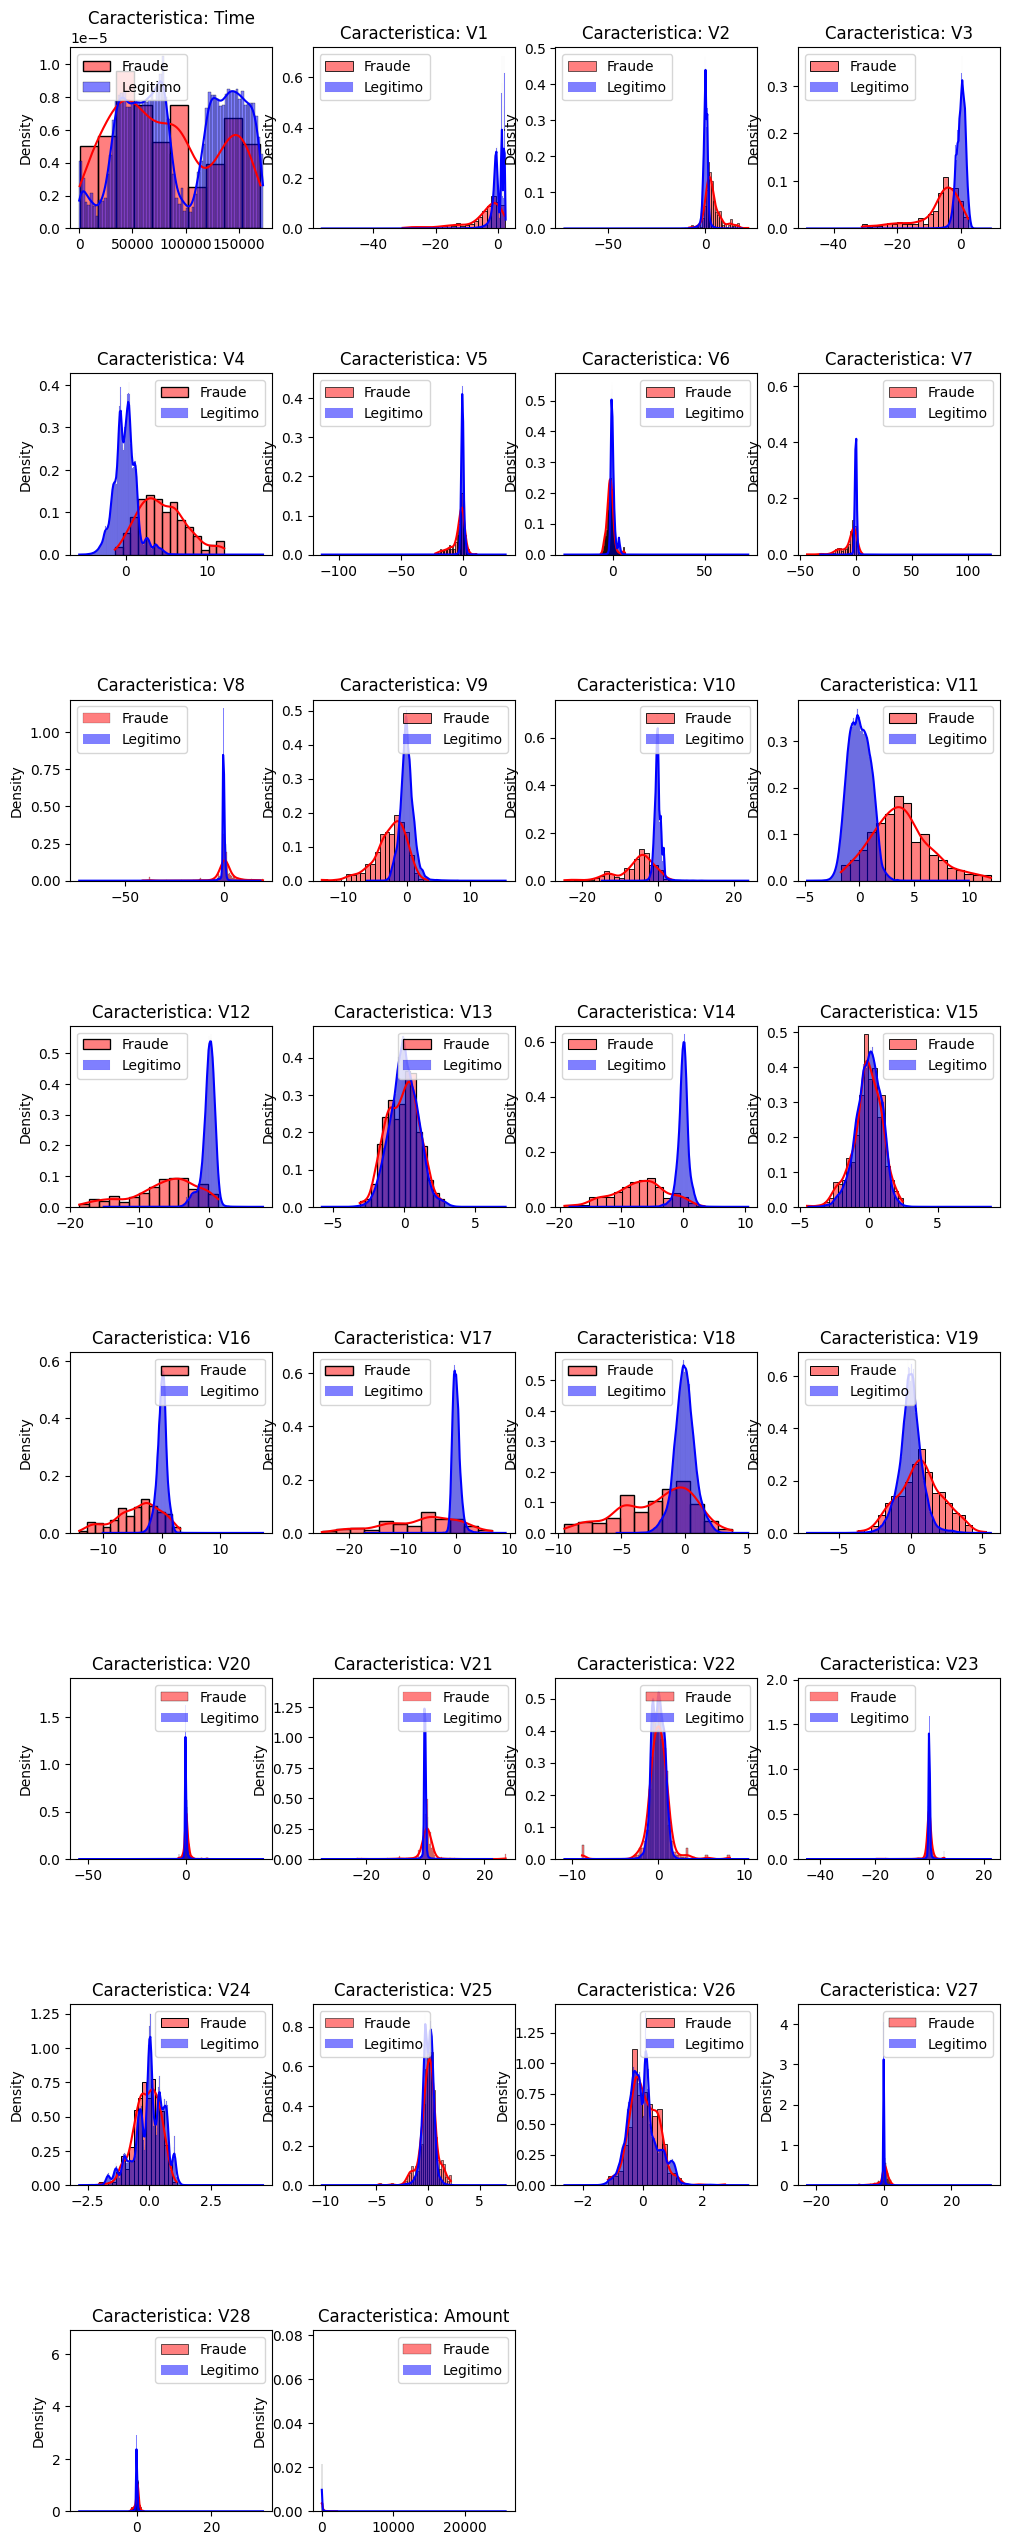

In [19]:
features = df.drop("Class", axis=1)
plt.figure(figsize=(12, 32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Usando histplot para los casos donde Class == 1
    sns.histplot(data=df[df["Class"] == 1], x=f, kde=True,
    color="red", stat="density", label="Fraude", alpha=0.5)
    # Usando histplot para los casos donde Class == 0
    sns.histplot(data=df[df["Class"] == 0], x=f, kde=True,
    color="blue", stat="density", label="Legitimo", alpha=0.5)
    ax.set_xlabel('')
    ax.set_title(f"Caracteristica: {f}")
    ax.legend()
plt.show()

Cracterísticas

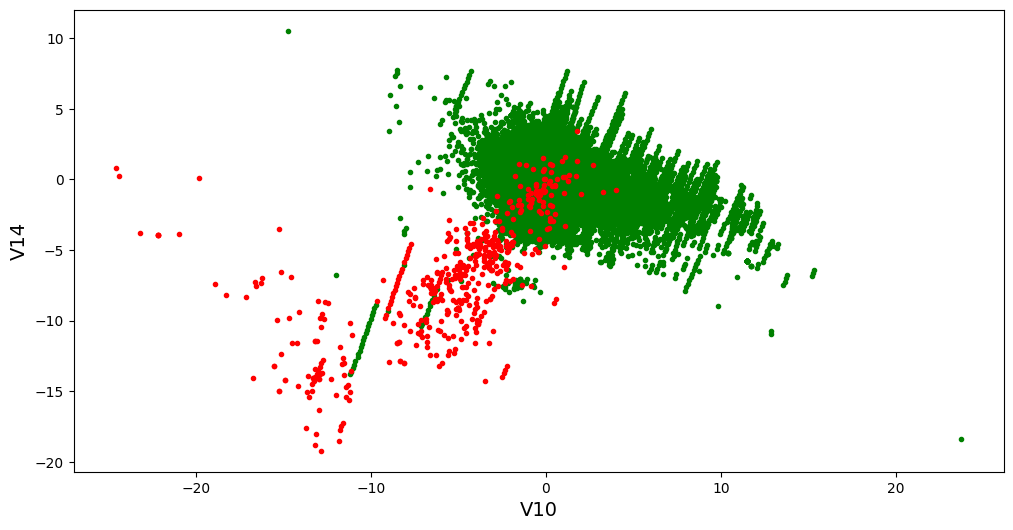

In [20]:
plt.figure(figsize=(12, 6))
plt.scatter(df["V10"][df['Class'] == 0], df["V14"][df['Class'] == 0], c="g", marker=".")
plt.scatter(df["V10"][df['Class'] == 1], df["V14"][df['Class'] == 1], c="r", marker=".")
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

 Eliminamos las características Time y Amount

In [21]:
#rango similar al resto y no son muy significativas.
df = df.drop(["Time", "Amount"], axis=1)

Copiamos y mostramos la variable X

In [22]:
X = df[["V10", "V14"]].copy()

In [23]:
from sklearn.cluster import KMeans

Ejecutamos Kmeans con 5 clusters

In [24]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

Dibujamos gráficamente el límite de decisión de los 5 clusters

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


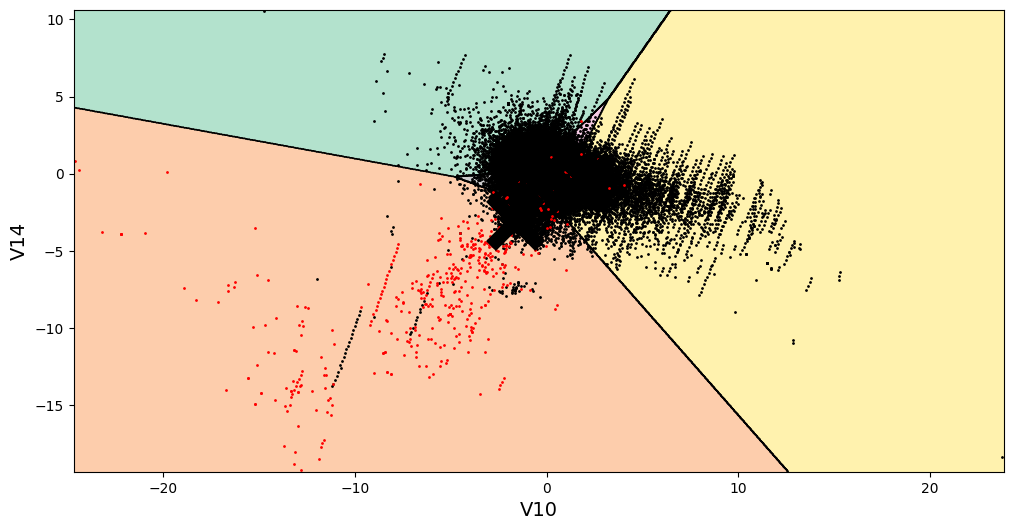

In [28]:
plt.figure(figsize=(12, 6))
plot_decision_boundaries(kmeans, X.values, df["Class"].values)
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

Métricas legales e ilegales para cada cluster

In [30]:
from collections import Counter

counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[df['Class'] == 1].tolist())
print("Número de muestras por cluster:")

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are malicious samples"
    .format(
    key, counter[key], bad_counter[key]))

Número de muestras por cluster:
Label 0 has 48659 samples - 6 are malicious samples
Label 1 has 5631 samples - 429 are malicious samples
Label 2 has 121724 samples - 18 are malicious samples
Label 3 has 27404 samples - 8 are malicious samples
Label 4 has 81389 samples - 31 are malicious samples


 KMeans para todo el conjunto de datos

In [31]:
X = df.drop("Class", axis=1)
y = df["Class"].copy()

In [32]:
from sklearn.cluster import KMeans

Evaluamos los clúster y el contenido de todos los datos

In [33]:
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[y == 1].tolist())
for key in sorted(counter.keys()):
    print("Cluster {0} tiene {1}Ejemplos-{2} ilegales"
    .format(
    key, counter[key], bad_counter[key]))

Cluster 0 tiene 48659Ejemplos-6 ilegales
Cluster 1 tiene 5631Ejemplos-429 ilegales
Cluster 2 tiene 121724Ejemplos-18 ilegales
Cluster 3 tiene 27404Ejemplos-8 ilegales
Cluster 4 tiene 81389Ejemplos-31 ilegales


In [34]:
from sklearn.ensemble import RandomForestClassifier

Características interesantes

In [35]:
clf_rnd = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf_rnd.fit(X, y)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

 características mas importantes

In [37]:
feature_importances = {name: score for name, score in zip(list(df),
clf_rnd.feature_importances_)}
feature_importances_sorted = \
pd.Series(feature_importances).sort_values(ascending=False)

 Reducimos el conjunto de datos a las siete más importantes

In [38]:
X_reducido = X[list(feature_importances_sorted.head(7).index)].copy()
X_reducido

,V17,V14,V16,V12,V10,V11,V18
0,0.207971,-0.311169,-0.470401,-0.617801,0.090794,-0.551600,0.025791
1,-0.114805,-0.143772,0.463917,1.065235,-0.166974,1.612727,-0.183361
2,1.109969,-0.165946,-2.890083,0.066084,0.207643,0.624501,-0.121359
3,-0.684093,-0.287924,-1.059647,0.178228,-0.054952,-0.226487,1.965775
4,-0.237033,-1.119670,-0.451449,0.538196,0.753074,-0.822843,-0.038195
...,...,...,...,...,...,...,...
284802,1.991691,4.626942,1.107641,2.711941,4.356170,-1.593105,0.510632
284803,-0.025693,-0.675143,-0.711757,0.915802,-0.975926,-0.150189,-1.221179
284804,0.313502,-0.510602,0.140716,0.063119,-0.484782,0.411614,0.395652
284805,0.509928,0.449624,-0.608577,-0.962886,-0.399126,-1.933849,1.113981


In [39]:
from sklearn.cluster import KMeans

 reentrenar y predecir el conjunto reducido

In [40]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_reducido)

Evaluamos los clusters y el contenido que se ha formado

In [41]:
counter = Counter(clusters.tolist())
bad_counter = Counter(clusters[y == 1].tolist())
for key in sorted(counter.keys()):
    print("Cluster {0} tiene {1} ejemplos - {2} ilegales"
    .format(
    key, counter[key], bad_counter[key]))

Cluster 0 tiene 109253 ejemplos - 19 ilegales
Cluster 1 tiene 124538 ejemplos - 17 ilegales
Cluster 2 tiene 30408 ejemplos - 161 ilegales
Cluster 3 tiene 308 ejemplos - 265 ilegales
Cluster 4 tiene 20300 ejemplos - 30 ilegales


Calculamos la Pureza

In [44]:
print("Estimacion de la Pureza:", purity_score(y, clusters))

Estimacion de la Pureza: 0.9990519895929524


Calculamos el coeficiente de Shiloutte

In [49]:
print("Estimación Shiloutte: ", metrics.silhouette_score(X_reducido,clusters, sample_size=10000))

Estimación Shiloutte:  0.18156377799178902


 Calculamos el índice de Calinski Harabasz

In [50]:
print("Estimación Calinski harabasz: ",
metrics.calinski_harabasz_score(X_reducido, clusters))

Estimación Calinski harabasz:  38466.001407022675
